# Predict Bike Sharing Demand with AutoGluon Template

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.9 Python 3.8 CPU Optimized)`

### Install packages

In [5]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

  Using cached pip-22.3.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1
  Using cached setuptools-65.7.0-py3-none-any.whl (1.2 MB)
  Using cached wheel-0.38.4-py3-none-any.whl (36 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.34.2
    Uninstalling wheel-0.34.2:
      Successfully uninstalled wheel-0.34.2
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.3.0
    Uninstalling setuptools-59.3.0:
      Successfully uninstalled setuptools-59.3.0
  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
  Using cached bokeh-2.0.1.tar.gz (8.6 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for bokeh: filename=bokeh-2.0.1-py3-none-any.whl size=9080017 sha256=e33409affc9bb7ef2f82c0ea3c187ad35ca7968af47c103fb012ee5cc5dfac10
  Stored in directory: /root/.cache/pip/wheels/df/5e/9c/8bd156f0e2

### Setup Kaggle API Key

In [ ]:
pip install kaggle

In [2]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "guosue"
kaggle_key = "9ecb0d7a7f3d8d6824f9a1d4c42b5b8d"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

In [13]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0%|                                                | 0.00/189k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 189k/189k [00:00<00:00, 5.29MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [7]:
import pandas as pd
from autogluon.tabular import TabularPredictor

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv")
train['datetime'] = pd.to_datetime(train.datetime)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [10]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [11]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv')
test['datetime'] = pd.to_datetime(test.datetime)
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [12]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv')
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [ ]:
predictor = TabularPredictor(label='count', 
                             learner_kwargs={'ignored_columns': ["casual", "registered"]},
                             problem_type="regression", 
                             eval_metric="root_mean_squared_error").fit(
    train_data = train,
    time_limit = 600,
    presets = 'best_quality'
)

### Review AutoGluon's training run with ranking of models that did the best.

In [ ]:
predictor.fit_summary()

In [22]:
predictor.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-52.853502,12.685561,431.831341,0.000955,0.467681,3,True,15
1,RandomForestMSE_BAG_L2,-53.356546,11.869560,402.206018,0.589281,25.594937,2,True,12
2,ExtraTreesMSE_BAG_L2,-53.936101,11.877827,384.318130,0.597549,7.707049,2,True,14
3,LightGBM_BAG_L2,-55.184524,11.497777,398.061675,0.217498,21.450594,2,True,11
4,CatBoost_BAG_L2,-55.812904,11.332536,441.893958,0.052257,65.282877,2,True,13
5,LightGBMXT_BAG_L2,-60.533326,15.289854,428.006314,4.009576,51.395233,2,True,10
6,KNeighborsDist_BAG_L1,-84.125061,0.039434,0.030308,0.039434,0.030308,1,True,2
7,WeightedEnsemble_L2,-84.125061,0.040090,0.449716,0.000656,0.419408,2,True,9
8,KNeighborsUnif_BAG_L1,-101.546199,0.040479,0.033875,0.040479,0.033875,1,True,1
9,RandomForestMSE_BAG_L1,-116.544294,0.542696,10.196773,0.542696,10.196773,1,True,5


### Create predictions from test dataset

In [23]:
predictions = predictor.predict(test)
predictions.head()

0    23.176855
1    41.161510
2    44.734001
3    48.289375
4    50.841335
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [24]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.751762
std        90.341621
min         2.949691
25%        21.056694
50%        62.625549
75%       170.281921
max       365.704437
Name: count, dtype: float64

In [25]:
# How many negative values do we have?
predictions.lt(0).value_counts()

False    6493
Name: count, dtype: int64

In [27]:
predictions.head()

0    23.176855
1    41.161510
2    44.734001
3    48.289375
4    50.841335
Name: count, dtype: float32

In [29]:
# Set them to zero
predictions.iloc[predictions.lt(0)] = 0

### Set predictions to submission dataframe, save, and submit

In [30]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [31]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|████████████████████████████████████████| 188k/188k [00:02<00:00, 90.5kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [8]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 3

fileName                        date                 description                                          status    publicScore  privateScore  
------------------------------  -------------------  ---------------------------------------------------  --------  -----------  ------------  
submission.csv                  2023-01-13 00:42:42  first raw submission                                 complete  1.80696      1.80696       


#### Initial score of `1.80696`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>],
       [<AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>]], dtype=object)

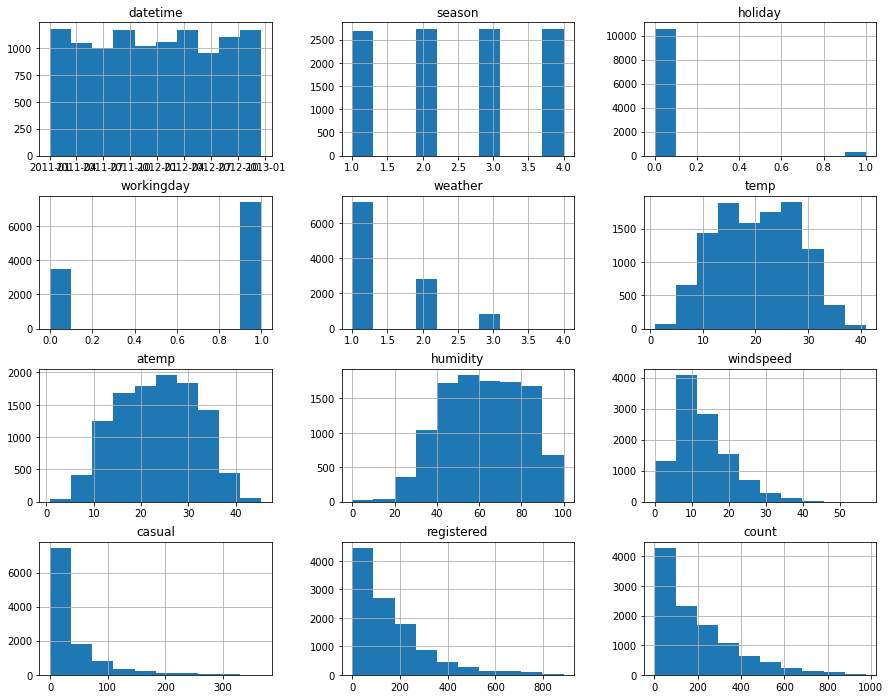

In [17]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(15,12))

In [18]:
# create a new feature
def parse_datetime(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    # df['time'] = df.datetime.dt.strftime('%H:%M:%S')
    df['week'] = df['datetime'].dt.isocalendar().week
    df['weekday'] = df['datetime'].dt.dayofweek
parse_datetime(train)
parse_datetime(test)
train.drop(["datetime"], axis=1, inplace=True)
test.drop(["datetime"], axis=1, inplace=True)



## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [19]:
categorical_cols = ["hour","weekday","week","month","year", "season","weather"]

for col in categorical_cols:
    train[col] = train[col].astype("category")

In [23]:
# View are new feature
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  int64   
 2   workingday  10886 non-null  int64   
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   casual      10886 non-null  int64   
 9   registered  10886 non-null  int64   
 10  count       10886 non-null  int64   
 11  year        10886 non-null  category
 12  month       10886 non-null  category
 13  day         10886 non-null  int64   
 14  hour        10886 non-null  category
 15  week        10886 non-null  category
 16  weekday     10886 non-null  category
dtypes: category(7), float64(3), int64(7)
memory usage: 928.4 KB


array([[<AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>],
       [<AxesSubplot:title={'center':'day'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

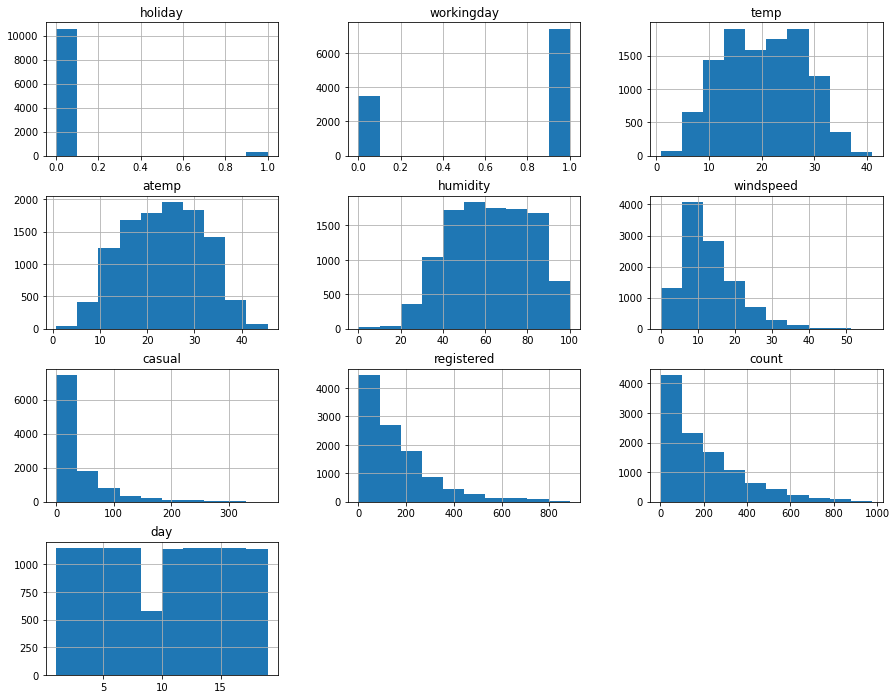

In [24]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(15,12))

## Step 5: Rerun the model with the same settings as before, just with more features

In [ ]:
predictor_new_features = TabularPredictor(label='count', 
                             learner_kwargs={'ignored_columns': ["casual", "registered"]},
                             problem_type="regression", 
                             eval_metric="root_mean_squared_error").fit(
    train_data = train,
    time_limit = 600,
    presets = 'best_quality'
)

In [ ]:
predictor_new_features.fit_summary()

In [63]:
predictor_new_features.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-33.342030,13.021330,503.693073,0.000560,0.304730,3,True,16
1,ExtraTreesMSE_BAG_L2,-33.556170,12.419700,399.011997,0.568561,8.327782,2,True,14
2,WeightedEnsemble_L2,-33.628862,11.721501,391.101856,0.000834,0.457199,2,True,9
3,CatBoost_BAG_L2,-33.739834,12.019058,468.223788,0.167919,77.539572,2,True,13
4,RandomForestMSE_BAG_L2,-34.256519,12.429020,418.088303,0.577881,27.404088,2,True,12
5,LightGBM_BAG_L2,-34.283945,12.002933,410.755898,0.151793,20.071682,2,True,11
6,LightGBMXT_BAG_L2,-34.724536,12.247340,412.108991,0.396201,21.424775,2,True,10
7,LightGBMXT_BAG_L1,-34.732945,6.593236,55.526561,6.593236,55.526561,1,True,3
8,LightGBM_BAG_L1,-35.927929,3.268029,39.967996,3.268029,39.967996,1,True,4
9,ExtraTreesMSE_BAG_L1,-38.649500,0.512539,5.267561,0.512539,5.267561,1,True,7


In [ ]:
predictor_info = predictor_new_features.info()
best_model_name = "CatBoost_BAG_L2"
best_model_info = predictor_info['model_info'][best_model_name]

print(best_model_info)

#print(f'Best Model Hyperparameters ({best_model_name}):')
print(best_model_info['hyperparameters'])

In [28]:
predictions = predictor_new_features.predict(test)
predictions.head()

0    12.134397
1     5.268426
2     4.387791
3     3.413694
4     3.361913
Name: count, dtype: float32

In [29]:
# Remember to set all negative values to zero
predictions.iloc[predictions.lt(0)] = 0

In [31]:
# Same submitting predictions
submission_new_features = pd.read_csv('sampleSubmission.csv')
submission_new_features["count"] = predictions
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [32]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 374kB/s]
Successfully submitted to Bike Sharing Demand

In [33]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                        date                 description                                          status    publicScore  privateScore  
------------------------------  -------------------  ---------------------------------------------------  --------  -----------  ------------  
submission_new_features.csv     2023-01-13 02:40:45  new features                                         complete  0.42236      0.42236       
submission.csv                  2023-01-13 00:42:42  first raw submission                                 complete  1.80696      1.80696       
bike-sharing-demand-prediction  2023-01-12 21:24:19                                                       complete  0.36376      0.36376       
Commit-version                  2023-01-12 21:11:00                                                       complete  0.36319      0.36319       


#### New Score of `0.42236`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [ ]:
# ref: https://auto.gluon.ai/dev/tutorials/tabular_prediction/tabular-indepth.html?highlight=gbm_options

import autogluon.core as ag

# nn_options = {  
#     'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability 
# }


gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_leaves': ag.space.Int(lower=1000, upper=1500, default=1200),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   #'NN': nn_options, 
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

time_limit = 12*60  # train various models for ~12 min
num_trials = 5  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}


predictor_new_hpo = TabularPredictor(label='count', 
                 learner_kwargs={'ignored_columns': ["casual", "registered"]},
                 problem_type="regression", 
                 eval_metric="root_mean_squared_error").fit(
    train_data = train,
    time_limit = 600,
    presets = 'best_quality',
    hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
)



In [ ]:
predictor_new_hpo.fit_summary()

In [55]:
predictor_new_hpo.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-36.517161,0.000757,201.961801,0.000567,0.187541,2,True,4
1,LightGBM_BAG_L1/T3,-36.865917,0.000075,124.830890,0.000075,124.830890,1,True,3
2,LightGBM_BAG_L1/T1,-37.656720,0.000115,76.943370,0.000115,76.943370,1,True,1
3,WeightedEnsemble_L3,-37.970854,0.001331,525.339849,0.000836,0.148443,3,True,7
4,LightGBM_BAG_L2/T1,-38.052721,0.000386,418.946233,0.000073,51.432282,2,True,5
5,LightGBM_BAG_L2/T2,-39.246697,0.000422,473.759124,0.000109,106.245173,2,True,6
6,LightGBM_BAG_L1/T2,-47.402365,0.000123,165.739691,0.000123,165.739691,1,True,2


In [56]:
predictions_new_hpo = predictor_new_hpo.predict(test)

In [57]:
# Remember to set all negative values to zero
predictions_new_hpo.iloc[predictions_new_hpo.lt(0)] = 0

In [59]:
# Same submitting predictions
submission_new_hpo = pd.read_csv('sampleSubmission.csv')
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [60]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 318kB/s]
Successfully submitted to Bike Sharing Demand

In [61]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                        date                 description                                          status    publicScore  privateScore  
------------------------------  -------------------  ---------------------------------------------------  --------  -----------  ------------  
submission_new_hpo.csv          2023-01-13 05:27:54  new features with hyperparameters                    complete  0.52473      0.52473       
submission_new_features.csv     2023-01-13 02:40:45  new features                                         complete  0.42236      0.42236       
submission.csv                  2023-01-13 00:42:42  first raw submission                                 complete  1.80696      1.80696       
bike-sharing-demand-prediction  2023-01-12 21:24:19                                                       complete  0.36376      0.36376       


#### New Score of `0.52473`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

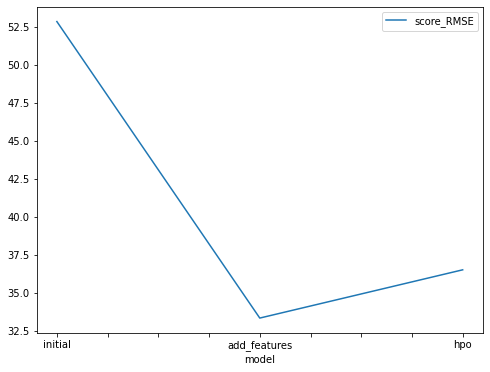

In [65]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score_RMSE": [52.853502, 33.342030, 36.517161]   	
    }
).plot(x="model", y="score_RMSE", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

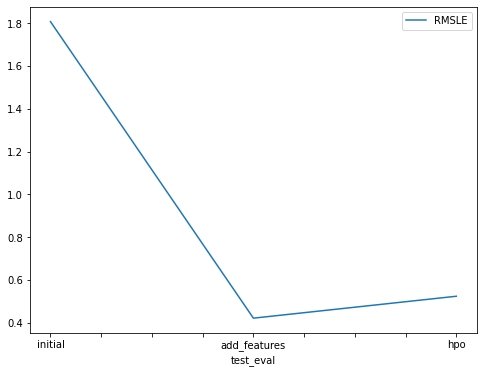

In [67]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "RMSLE": [1.80696, 0.42236, 0.52473]
    }
).plot(x="test_eval", y="RMSLE", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [69]:
# The 3 hyperparameters we tuned with the kaggle score as the result

hyperparams_df = pd.DataFrame({
    "model": ["initial_model", "add_features_model", "hpo_model"],
    "hpo1": ['default_vals', 'default_vals', 'GBM: num_leaves: lower=1000, upper=1500, default=1200'],
    "hpo2": ['default_vals', 'default_vals', 'NN: dropout_prob: 0.0, 0.5'],
    "hpo3": ['default_vals', 'default_vals', 'GBM: num_boost_round: 100'],
    "score": [1.80696, 0.42236, 0.52473]
})

hyperparams_df 

,model,hpo1,hpo2,hpo3,score
0,initial_model,default_vals,default_vals,default_vals,1.80696
1,add_features_model,default_vals,default_vals,default_vals,0.42236
2,hpo_model,"GBM: num_leaves: lower=1000, upper=1500, default=1200","NN: dropout_prob: 0.0, 0.5",GBM: num_boost_round: 100,0.52473
